## Importación de librerías

In [1]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

## Configuración de variables globales

In [2]:
with open('setup.json', 'r') as f:
    SETUP_JSON = json.load(f)
OUTPUT_PARQUET = SETUP_JSON['dataset_parquet']
LEARNING_RATE = SETUP_JSON['learning_rate']
EPOCHS = SETUP_JSON['epochs']

## Cargar el dataset

In [3]:
df = pd.read_parquet(OUTPUT_PARQUET) # Leer dataset limpio
df.shape

(8247888, 81)

In [4]:
# Mapeo de etiquetas
labels = df['Label'].unique()
labels_codes = df['Label Code'].unique()
label_mapping = {int(label_code): label for label_code, label in zip(labels_codes, labels)}
label_mapping

{0: 'Benign',
 1: 'FTP-BruteForce',
 2: 'SSH-Bruteforce',
 3: 'DoS attacks-GoldenEye',
 4: 'DoS attacks-Slowloris',
 5: 'DoS attacks-SlowHTTPTest',
 6: 'DoS attacks-Hulk',
 7: 'DDOS attack-LOIC-UDP',
 8: 'DDOS attack-HOIC',
 9: 'Brute Force -Web',
 10: 'Brute Force -XSS',
 11: 'SQL Injection',
 12: 'Infilteration',
 13: 'Bot'}

## Extracción de secuencias de paquetes

Obtener todas las secuencias de paquetes presentes en el dataset.

In [30]:
# Crear una copia del DataFrame original para no modificarlo directamente.
df_temp = df.copy()

# Cada vez que el valor de 'label' cambia, se incrementa el contador acumulativo.
df_temp['Sequence'] = (df_temp['Label'] != df_temp['Label'].shift()).cumsum()

# Agrupar el DataFrame por la columna 'sequence' y crear una lista de DataFrames.
sequences = []

# Tamaños de las secuencias
sequence_sizes = []

In [31]:
for sequence in df_temp.groupby('Sequence'):  # Iterar sobre cada DataFrame en la lista de secuencias.
    # Obtener el DataFrame correspondiente a la secuencia.
    sequence_df = sequence[1]  
    # Eliminar la columna 'sequence' de cada DataFrame, ya que solo se usó para agrupar.
    sequence_df.drop(columns='Sequence', inplace=True)  
    # Reiniciar los índices de cada DataFrame para que comiencen desde 0.
    sequence_df.reset_index(drop=True, inplace=True)
    # Agregar el DataFrame a la lista de secuencias.
    sequences.append(sequence_df)
    # Guardar el tamaño de cada secuencia.
    sequence_sizes.append(len(sequence_df)) 

## Análisis de las secuencias

In [32]:
sequences[0].head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label Code
0,0,0,0.866025,112641719.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,56320859.5,139.300036,56320958.0,56320761.0,Benign,0
1,0,0,0.866025,112641466.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,56320733.0,114.551299,56320814.0,56320652.0,Benign,0
2,0,0,0.866025,112638623.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,56319311.5,301.934596,56319525.0,56319098.0,Benign,0
3,22,6,0.866025,6453966.0,15.0,10.0,1239.0,2273.0,744.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,0
4,22,6,0.866025,8804066.0,14.0,11.0,1143.0,2209.0,744.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign,0


In [33]:
sequences[-1].head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label Code
0,53,17,0.707107,985.0,1.0,1.0,44.0,252.0,44.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
1,53,17,0.707107,1804.0,2.0,2.0,96.0,610.0,48.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
2,3389,6,0.500000,1695463.0,8.0,7.0,1144.0,1581.0,677.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
3,50461,6,0.707107,6.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0
4,3389,6,0.707107,1578949.0,8.0,7.0,1128.0,1581.0,661.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0


Análisis estadístico de las secuencias

In [35]:
# Número de características de cada secuencia
num_features = sequences[0].shape[1] - 2  # Restar 2 por 'Label' y 'Label Code'

# Obtener el número de secuencias
num_sequences = len(sequences)

# Obtener la media de paquetes por secuencia
mean = np.mean(sequence_sizes)

# Obtener la mediana de paquetes
median = np.median(sequence_sizes)

# Obtener la desviación estándar muestral (por defecto ddof=1)
deviation = np.std(sequence_sizes)

# Obtener la desviación estándar muestral (por defecto ddof=1)
shortest = min(sequence_sizes)

# Obtener la desviación estándar muestral (por defecto ddof=1)
longest = max(sequence_sizes)

print(f"Número de características por secuencia: {num_features}")
print(f"Número total de secuencias: {num_sequences}")
print(f"Número promedio de paquetes por secuencia: {mean}")
print(f"Mediana de paquetes: {median}")
print(f"Desviación estándar (muestral): {deviation}")
print(f"Secuencia más corta: {shortest} paquetes")
print(f"Secuencia más larga: {longest} paquetes")

Número de características por secuencia: 79
Número total de secuencias: 939866
Número promedio de paquetes por secuencia: 8.77559992594689
Mediana de paquetes: 1.0
Desviación estándar (muestral): 2310.1073395536337
Secuencia más corta: 1 paquetes
Secuencia más larga: 1418708 paquetes


## Separación de datos

In [39]:
X = []
y = []

sequence_length = int(mean)  # Longitud de la secuencia

for seq in sequences:
    sequence_X = seq.drop(columns=['Label', 'Label Code']) # Obtener las características
    sequence_Y = seq['Label Code'].iloc[0] # Obtener la etiqueta

    if len(sequence_X) < sequence_length:
        # Rellenar con ceros
        pad_width = sequence_length - len(sequence_X)
        sequence_X = np.pad(sequence_X, ((0, pad_width), (0, 0)), mode='constant')
    else:
        # Recortar
        sequence_X = sequence_X.iloc[:sequence_length]
        
    X.append(sequence_X)
    y.append(sequence_Y)

X = np.array(X)
y = np.array(y)

In [40]:
print(X.shape)
print(y.shape)

(939866, 8, 79)
(939866,)


## Normalización

Escalamiento de características

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, num_features)).reshape(num_sequences, sequence_length, num_features)

In [43]:
X_scaled[0][0]

array([-3.34893621e-01, -5.05856528e-01,  4.27309706e+00,  1.90391386e+01,
       -1.31035328e-02, -1.77540958e-02, -1.60787955e-02, -2.83747310e-03,
       -3.37921269e-01, -7.60402909e-02, -3.44252478e-01, -3.40766281e-01,
       -3.07754455e-01, -9.50559677e-02, -3.30285883e-01, -3.26493721e-01,
       -6.53409767e-02, -6.22485912e-02,  4.66123142e+01, -1.18278059e-01,
        1.76161709e+01,  5.33368562e+01,  1.91024557e+01,  3.62935324e+01,
       -1.31684659e-01,  1.76548318e+01,  4.04755286e+01, -5.73594512e-02,
       -4.59006964e-02, -5.29933556e-02, -5.46300700e-02, -2.73702994e-02,
       -2.69992463e-02,  0.00000000e+00, -2.98511711e-03,  0.00000000e+00,
       -1.59358552e-02, -2.32749894e-02, -6.10495080e-02, -5.81089215e-02,
       -7.73866609e-02, -3.42466675e-01, -3.52650036e-01, -3.47415370e-01,
       -1.66767913e-01, -1.86986661e-02, -2.69992463e-02, -2.39818990e-01,
       -2.55523322e-01, -4.32756881e-01, -8.35219102e-02, -2.98511711e-03,
       -2.39819300e-01, -

In [44]:
X_scaled.shape, y.shape

((939866, 8, 79), (939866,))

## Separar secuencias en entrenamiento, validación y prueba

Separación de datos

In [45]:
# Separar en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [46]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(601513, 8, 79) (601513,)
(150379, 8, 79) (150379,)
(187974, 8, 79) (187974,)


In [47]:
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [48]:
# Crea dataset y dataloader con batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Inicialización del modelo

In [49]:
# Modelo LSTM
class NetFlowLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)         # h_n shape: (1, batch, hidden)
        return self.classifier(h_n[-1])    # usar último estado oculto

model = NetFlowLSTM(input_dim=num_features, hidden_dim=32, output_dim=len(labels))

## Entrenamiento

In [50]:
# Configurar entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [51]:
# Función de predicción
def predict(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
    return outputs

In [52]:
# Función de evaluación
def evaluate_model(pred, y_tensor):
    loss = criterion(pred, y_tensor)
    pred = torch.argmax(pred, dim=1)
    acc = (pred == y_tensor).float().mean()
    return loss.item(), acc.item()

In [ ]:
# Entrenamiento del modelo
val_losses, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    val_pred = predict(model, X_val_tensor) # Predicción
    val_loss, val_acc = evaluate_model(val_pred, y_val_tensor) # Evaluación

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}")

## Gráfica del entrenamiento

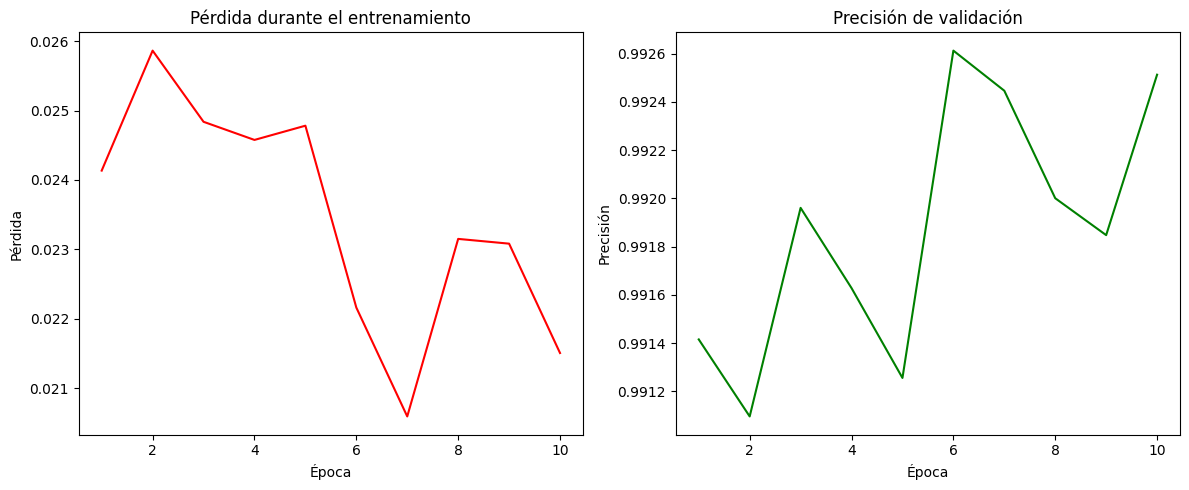

In [60]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Pérdidas
plt.subplot(1, 2, 1)
plt.plot(epochs_range, val_losses, color='red')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida durante el entrenamiento")

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, color='green')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Precisión de validación")

plt.tight_layout()
plt.show()

## Evaluación

Evaluación en el conjunto de test

In [63]:
test_pred = predict(model, X_test_tensor) # Predicción
test_loss, test_acc = evaluate_model(test_pred, y_test_tensor) # Evaluación

print(f"\n🔍 Evaluación final en test:")
print(f"Pérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_acc:.2f}")


🔍 Evaluación final en test:
Pérdida en test: 0.0222
Precisión en test: 0.99


Matriz de confusión de la predicción obtenida

In [ ]:
pred = torch.argmax(test_pred, dim=1).numpy()
pred_names = [label_mapping[y] for y in pred]
y_test_names = [label_mapping[y] for y in y_test]

# Calcular matriz de confusión
cm = confusion_matrix(y_test_names, pred_names)

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pred_names, yticklabels=y_test_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

## Evaluación por clase

Evaluación por cada clase en el conjunto de test

In [50]:
# Diccionario para almacenar los datos de test por clase
test_data_by_class = {}

# Asegúrate de que X_test_tensor y y_test_tensor estén alineados
for class_label in torch.unique(y_test_tensor):
    mask = y_test_tensor == class_label
    class_name = label_mapping[class_label.item()]
    test_data_by_class[class_name] = {
        'X': X_test_tensor[mask],
        'y': y_test_tensor[mask]
    }

In [51]:
for cls, data in test_data_by_class.items():
    X_cls, y_cls = data['X'], data['y']
    cls_pred = predict(model, X_cls) # Predicción
    cls_loss, cls_acc = evaluate_model(cls_pred, y_cls) # Evaluación
    print(f"Clase: {cls}, Pérdida: {cls_loss:.4f}, Precisión: {cls_acc:.2f}")

Clase: Benign, Pérdida: 0.0162, Precisión: 0.99
Clase: FTP-BruteForce, Pérdida: 0.0048, Precisión: 1.00
Clase: SSH-Bruteforce, Pérdida: 0.0430, Precisión: 0.99
Clase: DoS attacks-GoldenEye, Pérdida: 0.0711, Precisión: 0.98
Clase: DoS attacks-Slowloris, Pérdida: 0.0634, Precisión: 0.99
Clase: DoS attacks-SlowHTTPTest, Pérdida: 0.0065, Precisión: 1.00
Clase: DoS attacks-Hulk, Pérdida: 0.0005, Precisión: 1.00
Clase: DDOS attack-LOIC-UDP, Pérdida: 0.0012, Precisión: 1.00
Clase: DDOS attack-HOIC, Pérdida: 0.0002, Precisión: 1.00
Clase: Brute Force -Web, Pérdida: 1.3901, Precisión: 0.80
Clase: Brute Force -XSS, Pérdida: 1.3981, Precisión: 0.86
Clase: SQL Injection, Pérdida: 7.3095, Precisión: 0.00
Clase: Infilteration, Pérdida: 0.4007, Precisión: 0.93
Clase: Bot, Pérdida: 0.0248, Precisión: 0.99
